In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import corner
from scipy.stats import gaussian_kde

In [ ]:
dir = os.getcwd() #path to current working directory 

column_headers = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'm'] #column headers are not included in file
#units in original data file:
#x, y, z: parsecs
#vx, vy, vz: km/s
#m: solar masses

#import data into pandas data frame:
df = pd.read_table(os.path.join(dir,'M5_out_278.00.dat'), names = column_headers) #names option allows manual assigment of column headers


In [ ]:
# mks unit converstions factors

G = 6.674*10**-11 #Gravitational constant in mks                                                                                                                                                                          
kg_per_solar = 1.9891*10**30 #mass of sun in kg
m_per_pc = 3.086*10**16 #convert from parsec to meters


In [4]:
# asto unit converstion factors 

G_astro =  4.3*10**-3 #Gravitational constant in (km/s)^2 pc Msun^-1

In [5]:
#convert all data to mks units 

#df.x = df.x * m_per_pc
#df.y = df.y * m_per_pc
#df.z = df.z * m_per_pc
#df.m = df.m * kg_per_solar

Add new columns:

In [6]:
#add column for the radial distance of the star

df['r'] = (df.x**2 + df.y**2 + df.z**2)**(1/2)

In [7]:
#add column for the speed of the star

df['v'] = (df.vx**2 + df.vy**2 + df.vz**2)**(1/2) 

In [8]:
#add column that indicates whether the row contains a star (True) or a black hole (False)

df['star'] = df.m < 200

In [9]:
#add column to indicate which nuclear star cluster the star/bh originated in

iBH2 = df.loc[df['star'] == 0].index[1] #index of second black hole 
df['nsc'] = (df.index >= iBH2) + 1 

Center of mass:

In [ ]:
#calculate the center of mass:
xcom = (df.x*df.m).sum() / df.m.sum()
ycom = (df.y*df.m).sum() / df.m.sum()

In [ ]:
#center of mass of each cluster

xcom1 = (df.loc[df['nsc'] == 1].x*df.loc[df['nsc'] == 1].m).sum() / df.loc[df['nsc'] == 1].m.sum()
xcom2 = (df.loc[df['nsc'] == 2].x*df.loc[df['nsc'] == 2].m).sum() / df.loc[df['nsc'] == 2].m.sum()
print(xcom1, xcom2)

Corner plot:

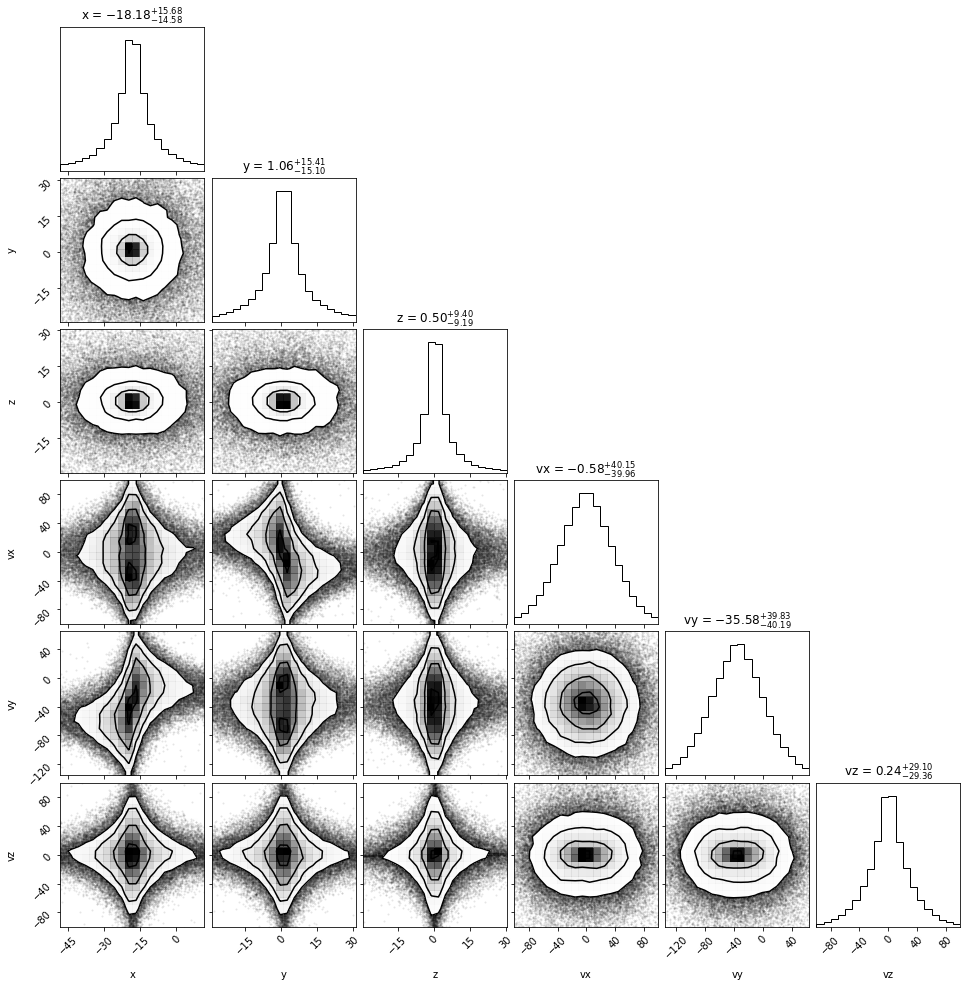

In [10]:
# corner figure of data set 

fig = corner.corner(df.loc[df.star==True][['x','y','z','vx','vy','vz']], range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


Generate a new, synthetic dataset that follows the same underlying distibution as the original dataset:

In [95]:
#
# stack our original data into the format that is expected by gaussian_kde

orig_data = np.vstack([df['x'].values, df['y'].values, df['z'].values, df['vx'].values, df['vy'].values, df['vz'].values])

In [100]:
# create the kde. bw_method = .001 value selected for best fit by eye. 

kde = gaussian_kde(orig_data, bw_method = .0001)

In [101]:
#resample the kde to create the synthetic dataset 

new_data = kde.resample(size=len(df['x'].values))

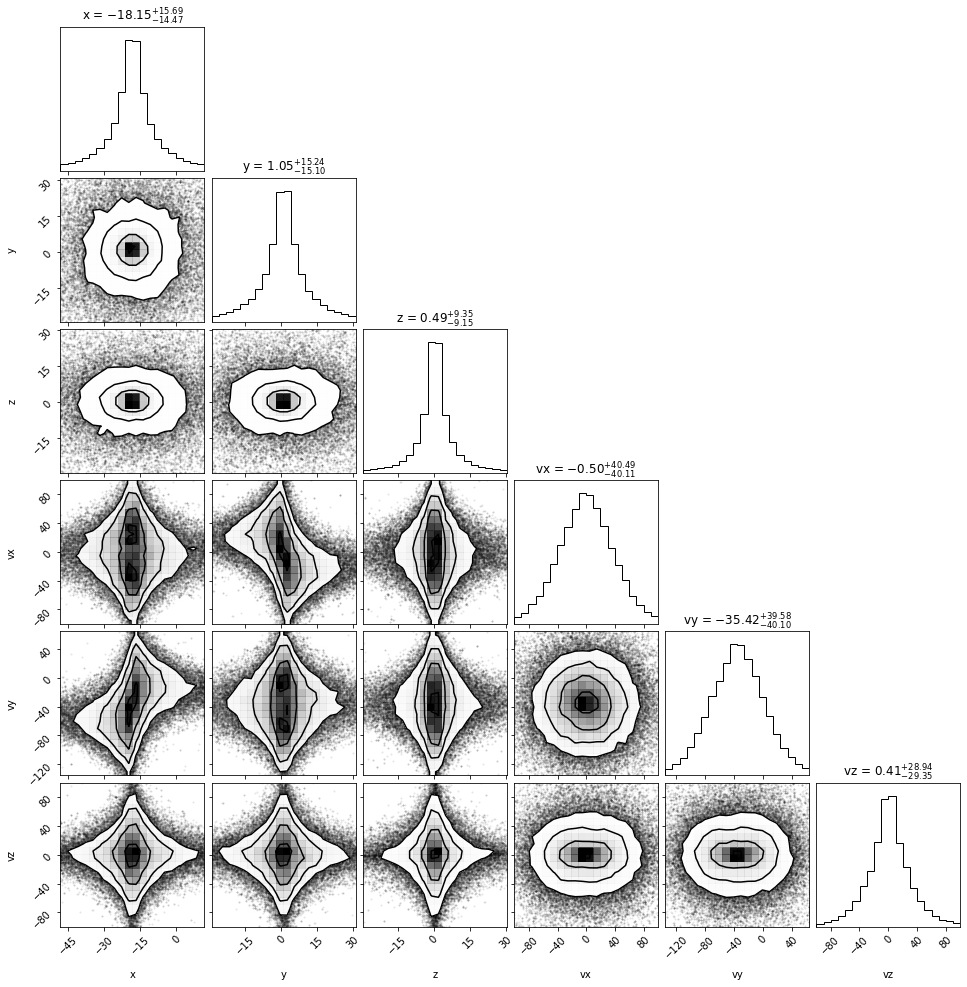

In [102]:
#corner plot using new synthetic data to mirror the one above 

fig = corner.corner(new_data.T, range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")
